<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Data-and-Function-Preparation" data-toc-modified-id="Data-and-Function-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data and Function Preparation</a></span></li><li><span><a href="#Preliminary-analysis" data-toc-modified-id="Preliminary-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preliminary analysis</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting</a></span></li></ul></div>

# 1.0 - Statcast Exploration
Fooling around with Statcast data

## Libraries

In [1]:
import os

import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

## Data

In [2]:
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [3]:
params = {
    'year': '2017',
    'game_type': 'R'
}

In [4]:
SQL = \
"""
SELECT
  t_events.event_id AS event_id,
  t_events.batter_id AS batter_id,
  t_batter.mlb_name AS batter_name,
  t_events.pitcher_id AS pitcher_id,
  t_pitcher.mlb_name AS pitcher_name,
  t_events.at_bat_key AS at_bat_key,
  t_events.game_pk AS game_pk,
  t_events.at_bat_number AS at_bat_number,
  t_events.pitch_number AS pitch_number,
  t_events.batter_team AS batter_team,
  t_events.pitcher_team AS pitcher_team,
  t_events.batter_side AS batter_side,
  t_events.pitcher_side AS pitcher_side,
  t_events.description AS description,
  t_events.events AS events,
  t_events.bb_type AS bb_type,
  t_events.effective_speed AS effective_speed,
  t_events.release_speed AS release_speed,
  t_events.release_spin_rate AS release_spin_rate,
  t_events.release_pos_x AS release_pos_x,
  t_events.release_pos_z AS release_pos_z,
  t_events.break_horizontal AS break_horizontal,
  t_events.break_vertical AS break_vertical,
  t_events.zone AS zone,
  t_events.plate_x AS plate_x,
  t_events.plate_z AS plate_z,
  t_events.sz_top AS sz_top,
  t_events.sz_bot AS sz_bot,
  t_events.launch_speed AS launch_speed,
  t_events.launch_angle AS launch_angle,
  t_events.spray_angle AS spray_angle,
  t_events.hit_x AS hit_x,
  t_events.hit_y AS hit_y,
  t_events.hit_distance_sc AS hit_distance_sc,
  (CASE WHEN t_events.events IN ('single', 'double', 'triple', 'home_run') THEN 1 ELSE 0 END) AS hit_flag,
  (CASE WHEN t_events.events = 'home_run' THEN 1 ELSE 0 END) AS hr_flag,
  (CASE WHEN t_events.description IN ('foul', 'foul_tip', 'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score', 'pitchout_hit_into_play', 'pitchout_hit_into_play_score', 'swinging_pitchout', 'swinging_strike', 'swinging_strike_blocked')
    THEN 1 ELSE 0 END) AS swung_flag,
  (CASE WHEN t_events.events IS NOT NULL AND t_events.events NOT IN ('caught_stealing_2b', 'caught_stealing_3b', 'caught_stealing_home', 'pickoff_1b', 'pickoff_2b', 'pickoff_caught_stealing_2b', 'pickoff_caught_stealing_3b', 'pickoff_caught_stealing_home')
    THEN 1 ELSE 0 END) AS final_pitch_flag,
  (CASE WHEN t_events.launch_speed IS NOT NULL AND t_events.launch_angle IS NOT NULL AND t_events.hit_distance_sc IS NULL
    THEN 1 ELSE 0 END) AS sc_fill_flag
FROM
  (
    SELECT
      event_id,
      batter AS batter_id,
      pitcher AS pitcher_id,
      CONCAT(game_pk, CAST(at_bat_number AS STRING)) AS at_bat_key,
      game_pk,
      at_bat_number,
      pitch_number,
      MAX(batter_team) AS batter_team,
      MAX(pitcher_team) AS pitcher_team,
      MAX(stand) AS batter_side,
      MAX(p_throws) AS pitcher_side,
      MAX(description) AS description,
      MAX(events) AS events,
      MAX(bb_type) AS bb_type,
      MAX(effective_speed) AS effective_speed,
      MAX(release_speed) AS release_speed,
      MAX(release_spin_rate) AS release_spin_rate,
      MAX(release_pos_x) AS release_pos_x,
      MAX(release_pos_z) AS release_pos_z,
      MAX(pfx_x) AS break_horizontal,
      MAX(pfx_z) AS break_vertical,
      MAX(zone) AS zone,
      MAX(plate_x) AS plate_x,
      MAX(plate_z) AS plate_z,
      MAX(sz_top) AS sz_top,
      MAX(sz_bot) AS sz_bot,
      MAX(launch_speed) AS launch_speed,
      MAX(launch_angle) AS launch_angle,
      MAX(spray_angle_est) AS spray_angle,
      MAX(hc_x) AS hit_x,
      MAX(hc_y) AS hit_y,
      MAX(hit_distance_sc) AS hit_distance_sc
    FROM
      `ad-fantasy-baseball.core.statcast_extended`
    WHERE
      game_year = {year}
        AND game_type = '{game_type}'
    GROUP BY 1, 2, 3, 4, 5, 6, 7
  ) t_events
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
  ) t_batter
    ON (t_events.batter_id = t_batter.mlb_id)
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
  ) t_pitcher
    ON (t_events.pitcher_id = t_pitcher.mlb_id)
"""

In [5]:
sql = SQL.format(**params)
df_events = read_gbq(query=sql, dialect='standard', project_id=PROJECT_ID, private_key=CREDENTIALS_PATH)

df_true = df_events.copy()

In [6]:
df_events.head(5)

,event_id,batter_id,batter_name,pitcher_id,pitcher_name,at_bat_key,game_pk,at_bat_number,pitch_number,batter_team,...,launch_angle,spray_angle,hit_x,hit_y,hit_distance_sc,hit_flag,hr_flag,swung_flag,final_pitch_flag,sc_fill_flag
0,491906.59.2,445055,Jon Jay,519322,Drew Storen,49190659,491906,59,2,CHC,...,None,NaN,None,None,None,0,0,0,0,0
1,491039.56.3,445055,Jon Jay,445197,Mike Dunn,49103956,491039,56,3,CHC,...,None,NaN,None,None,None,0,0,0,0,0
2,491376.49.2,445055,Jon Jay,541640,Erasmo Ramirez,49137649,491376,49,2,CHC,...,None,NaN,None,None,None,0,0,0,0,0
3,490406.15.1,445055,Jon Jay,607192,Tyler Glasnow,49040615,490406,15,1,CHC,...,None,NaN,None,None,None,0,0,0,0,0
4,492365.61.4,445055,Jon Jay,592773,Ryne Stanek,49236561,492365,61,4,CHC,...,None,NaN,None,None,None,0,0,0,0,0


In [7]:
df_events.shape

(718923, 39)

## Data and Function Preparation
Creating sub-datasets and functions for later use.

In [8]:
num_cols = [
    'effective_speed',
    'release_speed',
    'release_spin_rate',
    'release_pos_x',
    'release_pos_z',
    'break_horizontal',
    'break_vertical',
    'zone',
    'plate_x',
    'plate_z',
    'sz_top',
    'sz_bot',
    'launch_speed',
    'launch_angle',
    'hit_x',
    'hit_y',
    'hit_distance_sc'
]

df_events[num_cols] = df_events[num_cols].apply(pd.to_numeric)

In [9]:
_batted = df_events['bb_type'].notnull()
_hit = df_events['hit_flag'] == 1
_swung = df_events['swung_flag'] == 1
_final = df_events['final_pitch_flag'] == 1
_sc_fill = df_events['sc_fill_flag'] == 1
_rhb = df_events['batter_side'] == 'R'
_lhb = df_events['batter_side'] == 'L'
_rhp = df_events['pitcher_side'] == 'R'
_lhp = df_events['pitcher_side'] == 'L'

In [10]:
df_batted = df_events[_batted & ~_sc_fill]
df_hit = df_events[_hit & ~_sc_fill]
df_swung = df_events[_swung & ~_sc_fill]
df_final = df_events[_final & ~_sc_fill]
df_sof = df_events[(_swung | _final) & ~_sc_fill]
df_rhb = df_events[_rhb & ~_sc_fill]
df_lhb = df_events[_lhb & ~_sc_fill]
df_rhp = df_events[_rhp & ~_sc_fill]
df_lhp = df_events[_lhp & ~_sc_fill]
df_same_side = df_events[((_rhb & _rhp) | (_lhb & _lhp)) & ~_sc_fill]
df_oppo_side = df_events[((_rhb & _lhp) | (_lhb & _rhp)) & ~_sc_fill]

## Preliminary analysis
Looking at the "shape" of the data 

In [11]:
df_events.describe()

,at_bat_number,pitch_number,effective_speed,release_speed,release_spin_rate,release_pos_x,release_pos_z,break_horizontal,break_vertical,zone,...,launch_angle,spray_angle,hit_x,hit_y,hit_distance_sc,hit_flag,hr_flag,swung_flag,final_pitch_flag,sc_fill_flag
count,718923.000000,718923.000000,715391.000000,718923.000000,704543.000000,718830.000000,718830.000000,718830.000000,718830.000000,718783.000000,...,202895.000000,126800.000000,126800.000000,126800.000000,189337.000000,718923.000000,718923.000000,718923.000000,718923.000000,718923.000000
mean,39.110396,2.909011,88.156055,88.632251,2218.647248,-0.875081,5.892252,-0.226232,0.787102,9.119101,...,15.890017,0.237195,126.166642,122.625288,164.542393,0.058531,0.008474,0.464471,0.255559,0.018874
std,23.069082,1.733352,6.320162,6.023192,309.220602,1.915665,0.481829,0.902689,0.762002,4.207148,...,29.135562,21.755322,40.256504,43.787846,121.473976,0.234744,0.091662,0.498736,0.436175,0.136080
min,1.000000,1.000000,36.030000,40.900000,413.000000,-6.504800,-0.026300,-4.150400,-4.240900,1.000000,...,-87.127200,-67.360000,3.400000,2.260000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1.000000,83.905000,84.500000,2075.000000,-2.219400,5.622700,-0.983200,0.348025,5.000000,...,-3.824000,-17.810000,102.480000,89.507500,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,3.000000,89.555000,90.000000,2241.000000,-1.569200,5.938600,-0.331200,0.940900,11.000000,...,17.261000,-0.210000,125.560000,124.790000,172.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,58.000000,4.000000,93.023000,93.300000,2403.000000,0.638700,6.208700,0.512100,1.360400,13.000000,...,36.112850,18.790000,151.710000,158.570000,256.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,146.000000,17.000000,194.574000,104.200000,3680.000000,6.567600,9.529700,2.931200,6.303600,14.000000,...,89.850000,67.480000,248.000000,248.000000,574.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Plotting
Various exploratory plots using Statcast data

In [63]:
PALETTE_BIN = sns.color_palette(['#3A6EAB', '#AD3937'])
PALETTE_CONT = sns.color_palette("Blues", n_colors=11)
PALETTE_DIV = sns.color_palette("RdBu", n_colors=11)

CMAP_BIN = ListedColormap(PALETTE_BIN)
CMAP_CONT = ListedColormap(PALETTE_CONT)
CMAP_DIV = ListedColormap(PALETTE_DIV)

sns.set(rc={'figure.figsize':(16,9)})

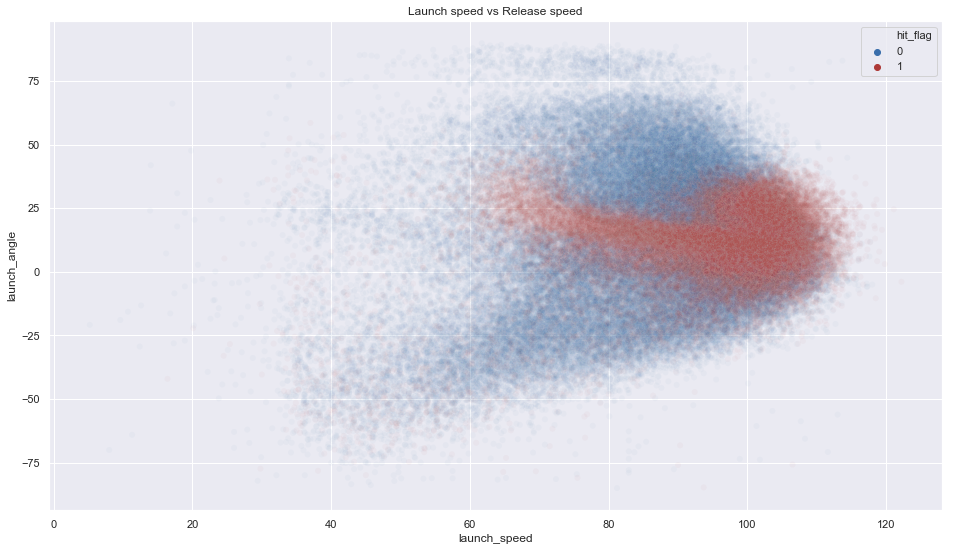

In [64]:
sns.scatterplot(data=df_batted,
                x='launch_speed',
                y='launch_angle',
                hue='hit_flag',
                palette=PALETTE_BIN,
                alpha=0.03)

plt.title('Launch speed vs Release speed')
plt.show()

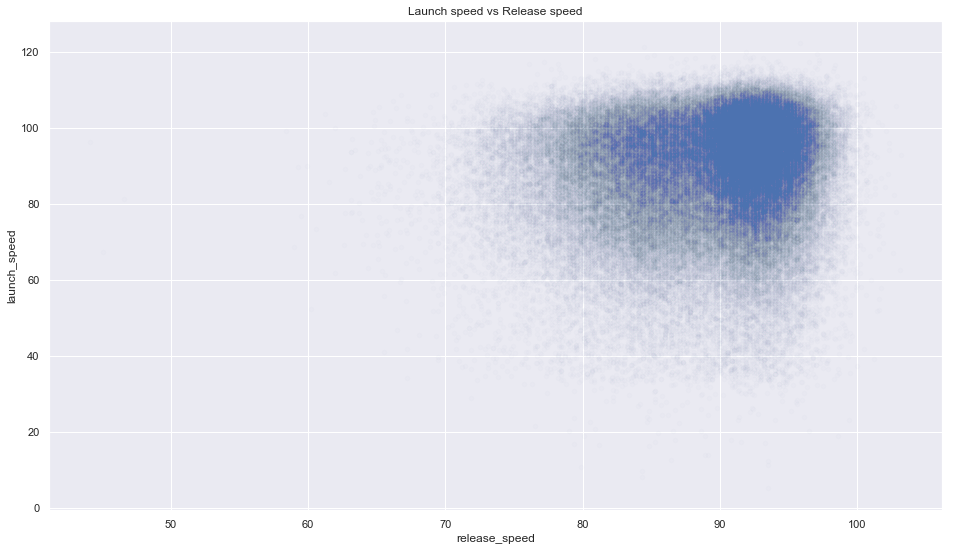

In [65]:
df_batted.plot(x='release_speed',
               y='launch_speed',
               kind='scatter',
               alpha=0.01,
               title='Launch speed vs Release speed')

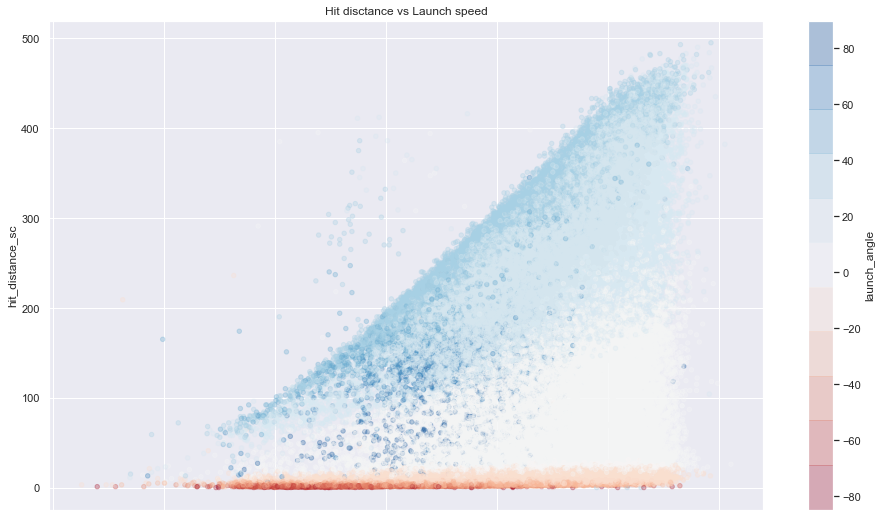

In [66]:
df_batted.plot(x='launch_speed',
               y='hit_distance_sc',
               c='launch_angle',
               kind='scatter',
               colormap=CMAP_DIV,
               alpha=0.3,
               title='Hit disctance vs Launch speed')

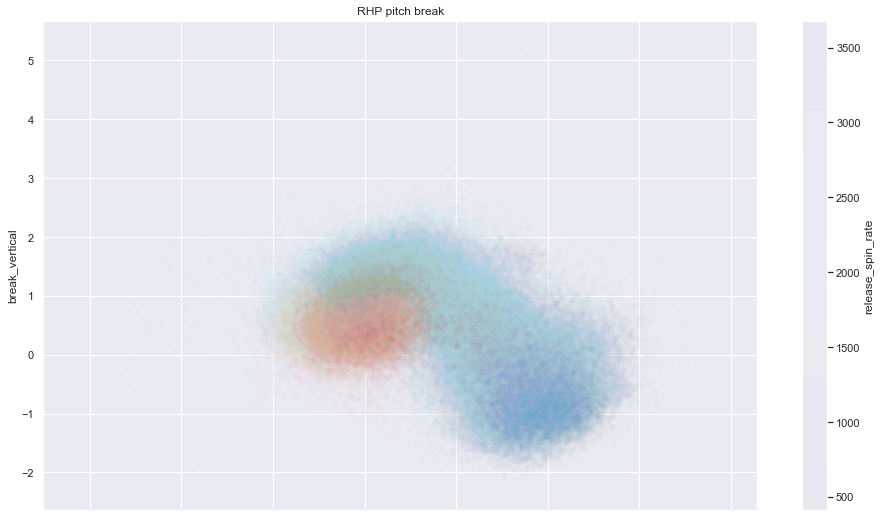

In [67]:
df_rhp.plot(x='break_horizontal',
            y='break_vertical',
            c='release_spin_rate',
            kind='scatter',
            colormap=CMAP_DIV,
            alpha=0.01,
            title='RHP pitch break')

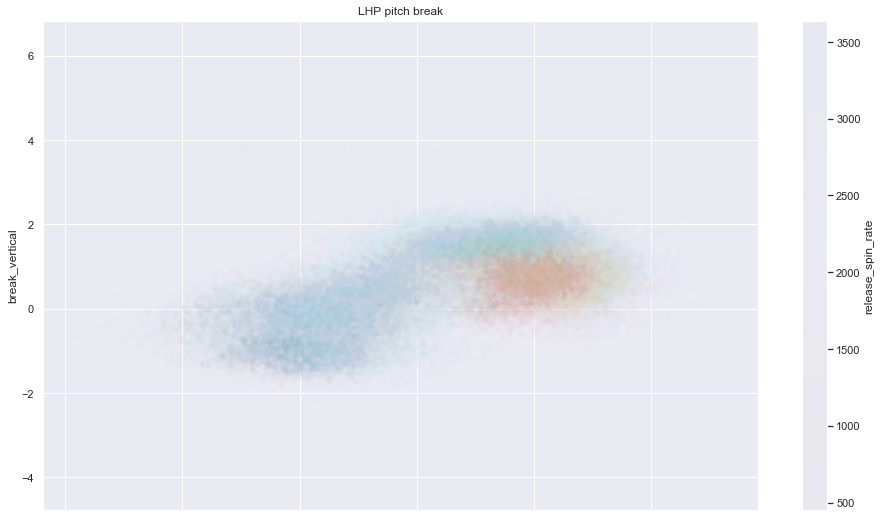

In [68]:
df_lhp.plot(x='break_horizontal',
            y='break_vertical',
            c='release_spin_rate',
            kind='scatter',
            colormap=CMAP_DIV,
            alpha=0.01,
            title='LHP pitch break')

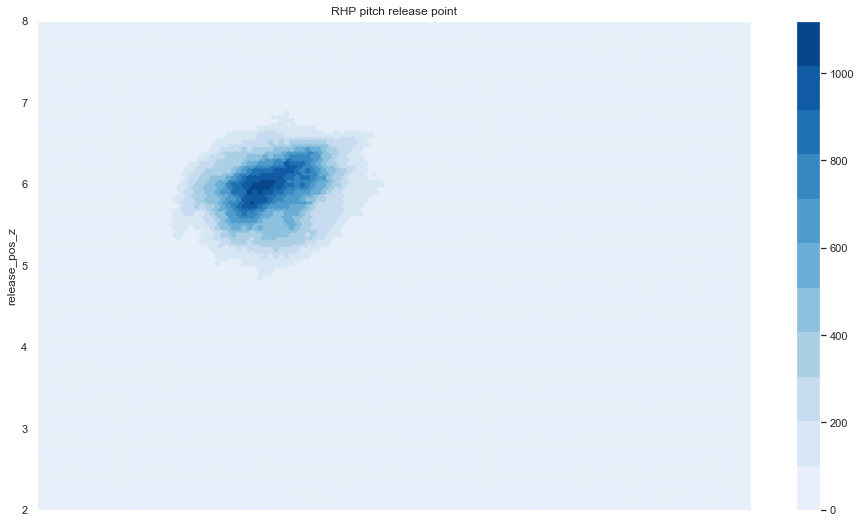

In [69]:
df_rhp.plot(x='release_pos_x',
            y='release_pos_z',
            xlim=(-5.5, 5.5),
            ylim=(2, 8),
            kind='hexbin',
            gridsize=150,
            colormap=CMAP_CONT,
            title='RHP pitch release point')

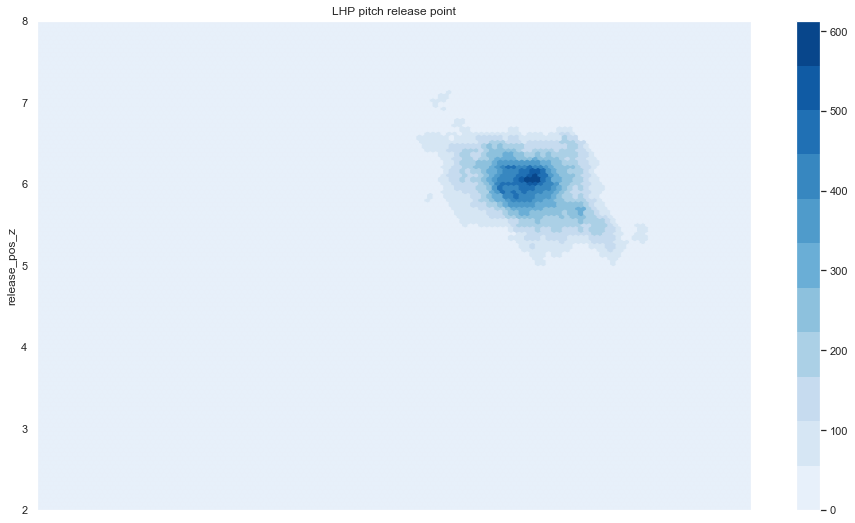

In [70]:
df_lhp.plot(x='release_pos_x',
            y='release_pos_z',
            xlim=(-5.5, 5.5),
            ylim=(2, 8),
            kind='hexbin',
            gridsize=150,
            colormap=CMAP_CONT,
            title='LHP pitch release point')

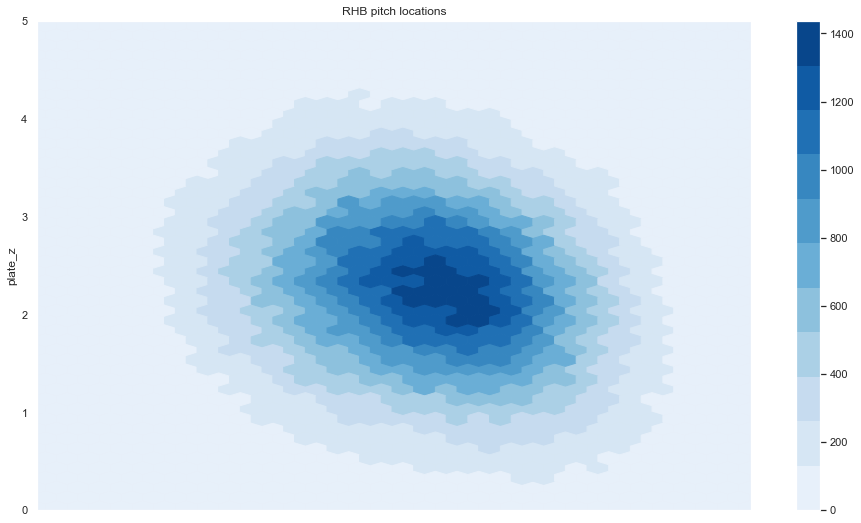

In [71]:
df_rhb.plot(x='plate_x',
            y='plate_z',
            xlim=(-2.5, 2.5),
            ylim=(0, 5),
            kind='hexbin',
            gridsize=150,
            colormap=CMAP_CONT,
            title='RHB pitch locations')

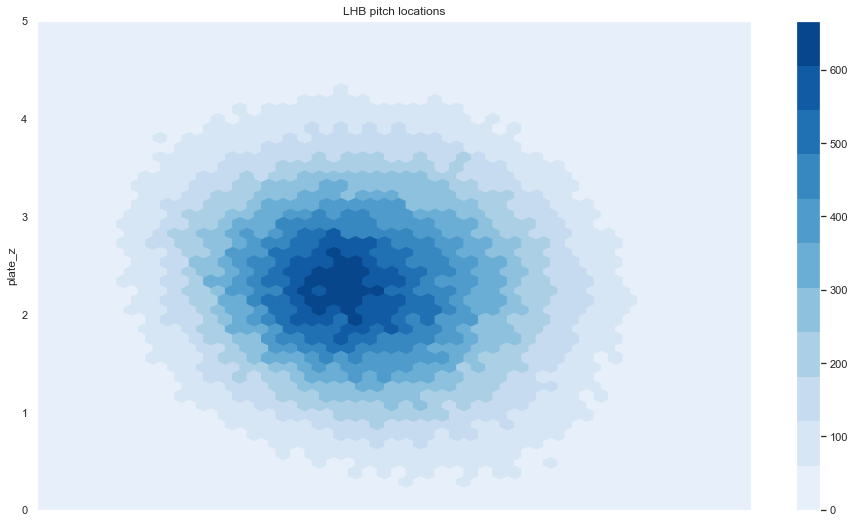

In [81]:
df_lhb.plot(x='plate_x',
            y='plate_z',
            xlim=(-2.5, 2.5),
            ylim=(0, 5),
            kind='hexbin',
            gridsize=150,
            colormap=CMAP_CONT,
            title='LHB pitch locations')

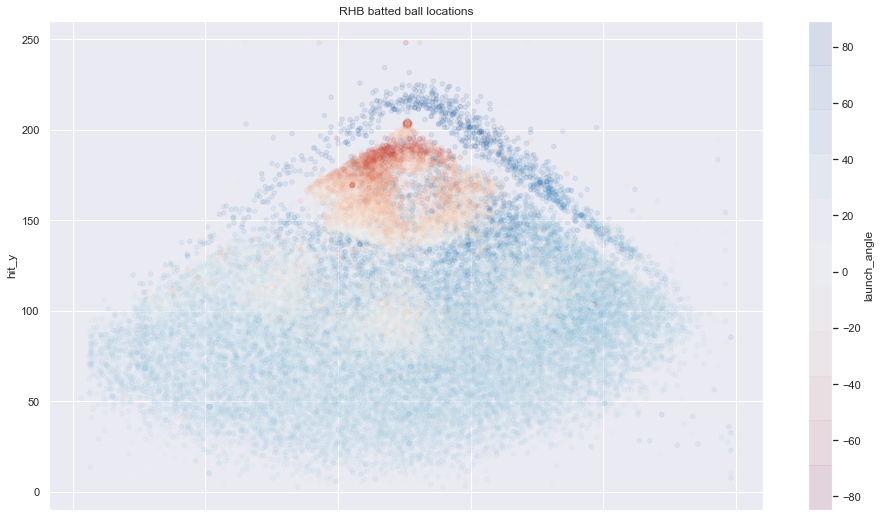

In [82]:
df_rhb.plot(x='hit_x',
            y='hit_y',
            kind='scatter',
            c='launch_angle',
            colormap=CMAP_DIV,
            alpha=0.1,
            title='RHB batted ball locations')

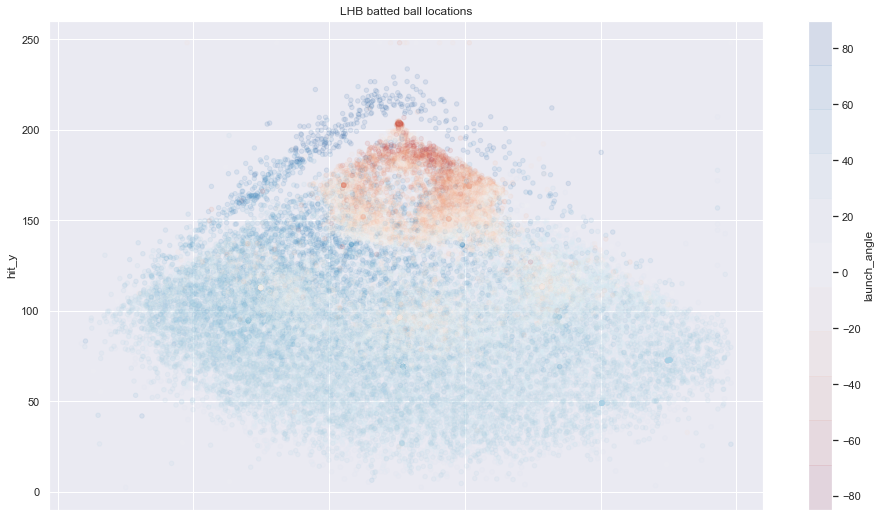

In [80]:
df_lhb.plot(x='hit_x',
            y='hit_y',
            kind='scatter', 
            c='launch_angle',
            colormap=CMAP_DIV,
            alpha=0.1,
            title='LHB batted ball locations')

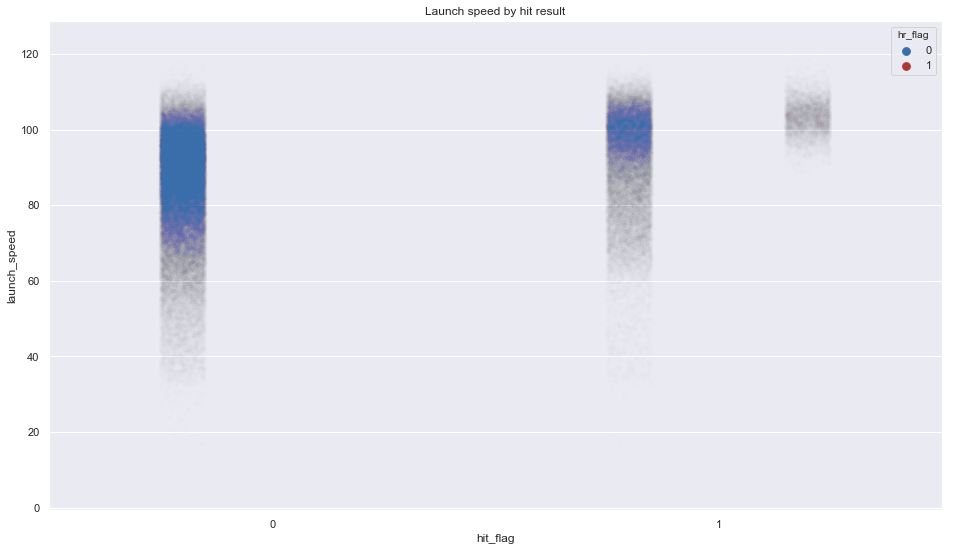

In [84]:
sns.stripplot(data=df_batted,
              x='hit_flag',
              y='launch_speed',
              hue='hr_flag',
              alpha=0.005,
              palette=PALETTE_BIN,
              jitter=True,
              dodge=True)

plt.title("Launch speed by hit result")
plt.show()

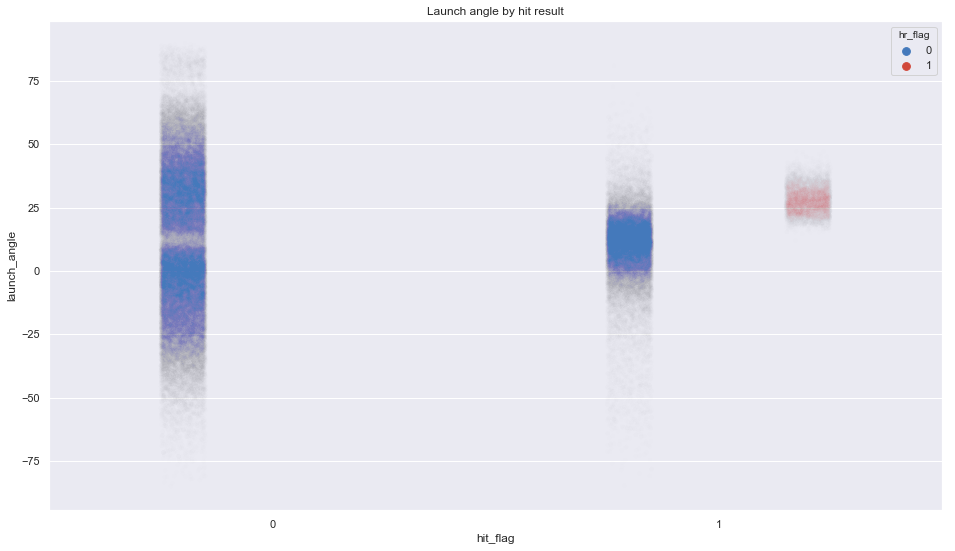

In [85]:
sns.stripplot(data=df_batted,
              x='hit_flag',
              y='launch_angle',
              hue='hr_flag',
              alpha=0.005,
              palette=pal_bin,
              jitter=True,
              dodge=True)

plt.title("Launch angle by hit result")
plt.show()

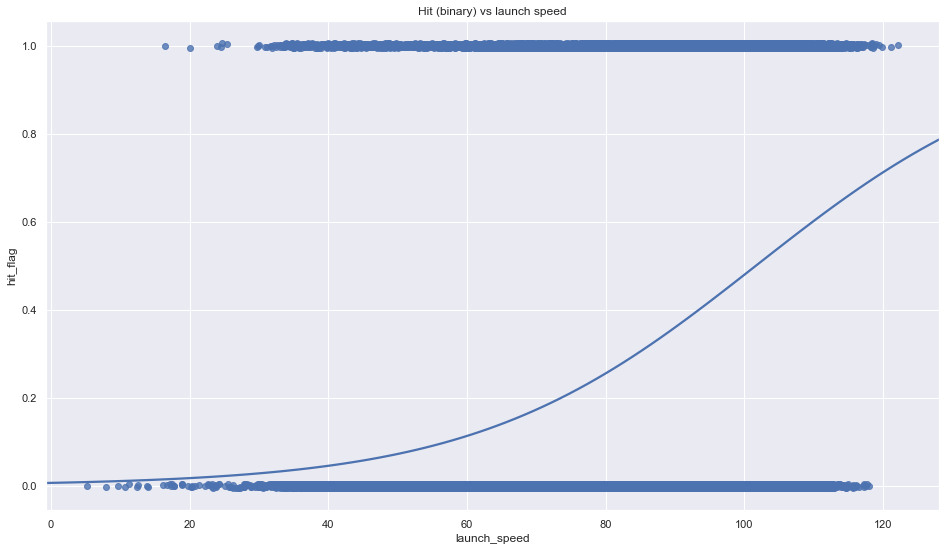

In [91]:
sns.regplot(data=df_batted,
            x='launch_speed',
            y='hit_flag',
            logistic=True,
            n_boot=100,
            ci=None,
            y_jitter=0.005)

plt.title("Hit (binary) vs launch speed")
plt.show()

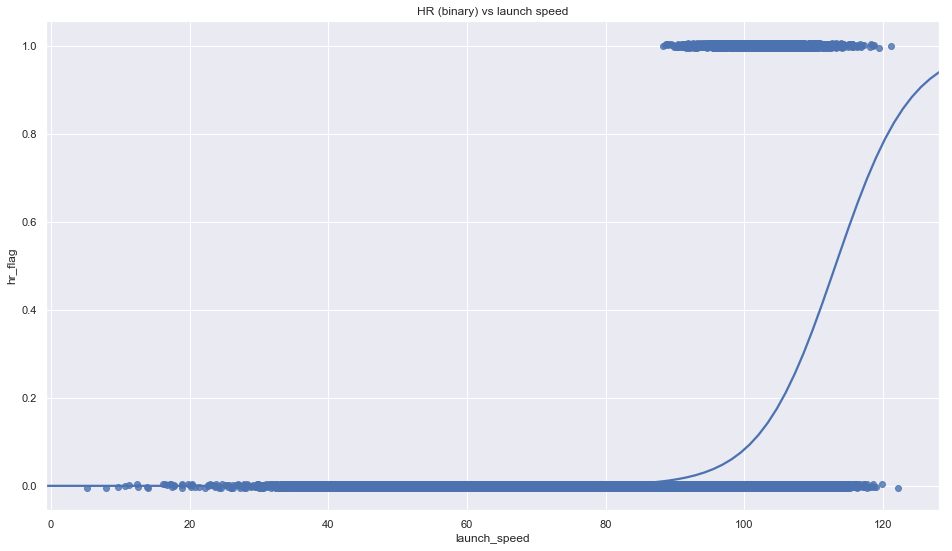

In [92]:
sns.regplot(data=df_batted,
            x='launch_speed',
            y='hr_flag',
            logistic=True,
            n_boot=100,
            ci=None,
            y_jitter=0.005)

plt.title("HR (binary) vs launch speed")
plt.show()